# Critical Collapse Study

Below is code to help study the formation of black holes. The equations integrated are described in the work by Bloomfield et. al.

arXiv paper on : [1504.02071](https://arxiv.org/pdf/1504.02071.pdf) ([ar5iv](https://ar5iv.org/abs/1504.02071))

For collapse with an approximate QCD equation of state, a previous work is

arXiv: [1801.06138](https://arxiv.org/pdf/1801.06138.pdf) ([ar5iv](https://ar5iv.org/abs/1801.06138))

## Import Modules

In [1]:
import numpy as np
import sys
from importlib import reload 
import scipy.interpolate as interp
import scipy.constants as const

import cython
%load_ext Cython

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Import MS, HM modules

...and reload modules if needed

In [2]:
# importing MS and HM modules. Reload modules if needed
try :
    reload(ms_hm.QCD_EOS)
    reload(ms_hm.MS)
    reload(ms_hm.HM)
except :
    print("Did not reload modules, they may not have been imported yet.")

import ms_hm
from ms_hm.QCD_EOS import *
from ms_hm.MS import *
from ms_hm.HM import *

Did not reload modules, they may not have been imported yet.


## Various functions that use the MS and HM classes

Functions below compute various things using the Misner-Sharp or Hernandez-Misher classes.

In [3]:
%%cython

import cython
cimport numpy as np

cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport exp
from libc.math cimport sqrt

from cython.parallel import prange

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef zero_crossing(np.ndarray x_in, double [::1] y):
    """
    Given an array of inputs y, find x where the function y(x) = 0
    """
    cdef int size = x_in.shape[0]
    cdef double [:] x = x_in
    cdef double w, zero=-1
    cdef int i
    
    for i in range(size-1): # loop through all y values
        if(y[i] * y[i+1] < 0): # if subsequent elements have opposite signs, a zero-crossing was found.
            # linearly extrapolate zero-crossing
            w = abs(y[i] / (y[i+1] - y[i])) 
            zero = x[i] * (1 - w) + x[i+1] * w
            break
            
    return zero

In [4]:
def mix_grid(left, right, n):
    """
    Function to generate coordinate spacings with a mix of uniform and logarithmic spacings,
    with uniform spacing at small values (0 to "left") then logarithmically spaced ("left" to "right").
    
    Returns an array of coordinate positions.
    """
    
    # Generate logarithmically spaced coordinates between "left" and "right"
    A = np.exp(np.linspace(left, right, n))
    dA = A[1] - A[0]
    
    # Generate uniformly spaced coordinates
    A = np.concatenate( (np.linspace(0, A[0], int(np.ceil(A[0] / dA)), endpoint=False), A))
    
    return A

def uni_grid(right, n):
    """
    Function to generate a uniformly-spaced array of coordinate positions
    
    Returns the array of uniformly spaced coordinates.
    """
    A = np.linspace(0, np.exp(right), n)
    return A

def exp_grid(left, right, n):
    """
    Function to generate an exponentially-spaced array of coordinate positions
    """
    # Generate logarithmically spaced coordinates between "left" and "right"
    A = np.logspace(left, right, n)
    A = np.concatenate( ([0], A))

    return A

In [5]:
# Check if a BH forms
# The MS run should proceed until MS until it breaks. If 2m / R > 1, return true
def BH_form(Abar, rho0, amp, default_steps=1500000, sm_sigma=0.0, fixw=False):
    
    ms = MS(Abar, rho0, amp, trace_ray=False, BH_threshold=-1,
        sm_sigma=sm_sigma, fixw=fixw)
    
    run_result = ms.adap_run_steps(default_steps)
    if run_result == -1 :
        return (True, run_result, ms.delta, ms)
    
    return (False, run_result, ms.delta, ms)

In [6]:
def find_crit(Abar, rho0, lower_amp, upper_amp,
    sm_sigma=0.0, fixw=False):
    """
    Binary search between lower and upper to find a critical amplitude
    (Note that this is NOT the critical density)
    return (critical, upper value)
    """
    upper_ms = -1
    lower_ms = -1
    bisection_factor = 1/2
    for i in range(20):
        try :
            amp_diff = upper_amp - lower_amp
            middle_amp = upper_amp - amp_diff*bisection_factor
            print('Iteration No', str(i), '-- Checking to see if a BH forms at amplitude', str(middle_amp),
                ' (bracket is ', lower_amp, '/', upper_amp, ')')

            forms, result, delta, ms = BH_form(Abar, rho0, middle_amp, sm_sigma=sm_sigma, fixw=fixw)

            if result > 0 : # Some sort of error during run
                print("Encountered error during run. Trying again with a different amplitude.")
                # change bisection factor (don't divide just in half; walk in by 1/4, 1/8, ... from the ends.)
                if bisection_factor >= 1/2 :
                    bisection_factor = (1-bisection_factor)/2
                else :
                    bisection_factor = 1-bisection_factor
            else :
                bisection_factor = 1/2
                if(forms == True):
                    upper_amp = middle_amp
                    upper_ms = ms
                else:
                    lower_amp = middle_amp
                    lower_ms = ms

        except Exception as e :
            print("Run failed! Stopping search. Reason below.")
            print(e)
            break
    
    print("Critical amplitude appears to be between", lower_amp, "and", upper_amp)
    try :
        upper_ms.plot_fields(True)
        plt.fig(2)
        lower_ms.plot_fields(True)
    except :
        pass

    return (lower_amp, upper_amp)

In [14]:
def find_mass(Abar, rho0, amp, mOverR_thresh=0.98,
        is_searching_for_crit=False, default_steps=1500000,
        MS_sm_sigma=0.0, HM_sm_sigma=15.0,
        HM_Abar=None, # can specify a different Abar for HM run
        HM_cflfac=0.1
    ):
    """
    Find mass of BHs for certain amplitude
    set is_searching_for_crit=True when searching for the critical point
    """
    print('Finding mass with amp ' + str(amp))
            
    # Perform an MS run without raytracing to get the overdensity delta
    ms = MS(Abar, rho0, amp, trace_ray=False, BH_threshold=-1e1, sm_sigma=MS_sm_sigma)
    ms.adap_run_steps(default_steps)
    delta = ms.delta
    
    # Perform an MS run with raytracing to get ICs for an HM run
    ms = MS(Abar, rho0, amp, trace_ray=True, BH_threshold=-1e1, sm_sigma=MS_sm_sigma)
    flag = ms.adap_run_steps(default_steps)
    if(flag != 0):
        raise ValueError('Not finishing ray-tracing with the amplitude ' + str(amp))
        
    # Perform an HM run
    hm = HM(ms, mOverR=mOverR_thresh, sm_sigma=HM_sm_sigma, Abar=HM_Abar, cflfac=HM_cflfac)
    bh_formed = hm.run_steps(default_steps) == 1
    if(not bh_formed and is_searching_for_crit==False):
        raise ValueError('Cannot get the target 2m/R with the amplitude ' + str(amp))
    
    return (delta, hm.BH_mass2(), ms, hm)

In [15]:
# Generate critical scaling data 
def critical_scaling_data(Abar, rho0, crit_amp, lower_amp, upper_amp, n=10, mOverR_thresh=0.98,
    MS_sm_sigma=0.0, HM_sm_sigma=15.0, HM_Abar=None, HM_cflfac=0.1):
    
    amps = 10**np.linspace(np.log10(lower_amp - crit_amp), np.log10(upper_amp - crit_amp), n) + crit_amp
    print("Attempting to find masses for runs with amplitudes:\n", amps)
    
    masses = [find_mass(Abar, rho0, amp, mOverR_thresh=mOverR_thresh, is_searching_for_crit=True,
        MS_sm_sigma=MS_sm_sigma, HM_sm_sigma=HM_sm_sigma, HM_Abar=HM_Abar, HM_cflfac=HM_cflfac) for amp in amps]
    return masses

## Simulation setup

Code below will set up grids (arrays) for running the simulations.

The grid of Abar values is linearly spaced from Abar = 0 to 5.650000000000001 then log spaced until Abar = 21.0


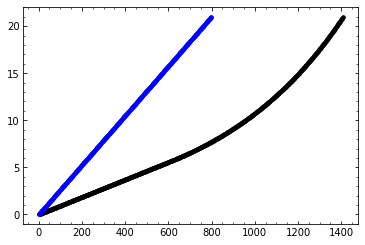

In [9]:
# simulation resolution parameter
# (Not exactly the number of gridpoints for a mixed grid)
n_mix = 800
n_uni = 800

# Generate an array of coordinate positions for the simulation to run at
lower = np.log(5.65) # The coordinates will be linearly spaced from 0 to e^lower
upper = np.log(21.0) # The coordinates will be log spaced from e^lower to e^upper
Abar_mix = mix_grid(lower, upper, n_mix)
Abar_uni = uni_grid(upper, n_uni)

plt.plot(Abar_mix, 'k.')
plt.plot(Abar_uni, 'b.')
print("The grid of Abar values is linearly spaced from Abar = 0 to", np.exp(lower),
      "then log spaced until Abar =", np.exp(upper))

## Test case to find BH mass

In [ ]:
# find_mass command that nominally works
# (Calls MS run w/o raytracing, MS run w/, HM run)
find_mass(Abar_mix, 1.0e0, 0.28, mOverR_thresh=0.98,
          MS_sm_sigma=0.0, HM_sm_sigma=15.0, HM_Abar=Abar_mix, HM_cflfac=0.1)
# find_mass command that nominally works
# (Calls MS run w/o raytracing, MS run w/, HM run)
find_mass(Abar_mix, 1.0e0, 0.28, mOverR_thresh=0.99,
          MS_sm_sigma=0.0, HM_sm_sigma=15.0, HM_Abar=Abar_mix, HM_cflfac=0.1)

Finding mass with amp 0.28
Initial w is 0.3316004747425083 and Horizon radius is 0.3454941494713355
Not Tracing ray and NO excision will be performed!
Horizon is found, MS run will be terminated! Finished at step 1042
Initial w is 0.3316004747425083 and Horizon radius is 0.3454941494713355
Tracing ray is enabled and excision will be performed!


In [24]:
2.609107139746319, 2.661047213525141

(2.609107139746319, 2.661047213525141)

## Critical scaling parameters

In [ ]:
# Find bounds on a critical point
lower_amp, upper_amp = find_crit(Abar_mix, # Coordinate grid
                                 1.0e0, # initial density 
                                 0.15, # Amplitude a BH does *not* form
                                 0.3, # amplitude a BH *does* form
                                 sm_sigma=0.0, # Hopefully no smoothing is needed here
                                 fixw=False # Fixed equation of state or not?
                                )

In [ ]:
# Get data to generate critical scaling exponent
crit_amp = (lower_amp+upper_amp)/2 # best guess for critical amplitude
data_lower_amp = upper_amp # look for critical data at/above the upper bound for the critical point
data_upper_amp = 1.05*upper_amp # Look for critical data at up to 5% larger amplitudes

scaling_data = critical_scaling_data(Abar_mix,
                      1.0e0, # Same density as above
                      crit_amp,
                      data_lower_amp,
                      data_upper_amp,
                      n=10, # Try to get masses at 10 points
                      mOverR_thresh=0.97,
                      MS_sm_sigma=0.0, HM_sm_sigma=15.0, HM_Abar=None, HM_cflfac=0.1)

In [ ]:
# importing MS and HM modules. Reload modules if needed
try :
    reload(ms_hm.QCD_EOS)
    reload(ms_hm.MS)
    reload(ms_hm.HM)
except :
    print("Did not reload modules, they may not have been imported yet.")

import ms_hm
from ms_hm.QCD_EOS import *
from ms_hm.MS import *
from ms_hm.HM import *

hm = HM(ms, mOverR=0.99, sm_sigma=14)
hm.run_steps(100)



## Critical data fit

Below is an example of all the code needed to find the critical scaling threshhold and exponent.

In [ ]:
# Find the critical point. It will be bounded between crit and lower.
(crit, lower) = find_crit()
# Find the mass of BHs at various amplitudes between lower_amp and lower_amp plus a bit.
res = critical_scaling(crit, lower_amp, lower_amp + 1e-2, 20)

In [ ]:
(a, b ) = np.polyfit(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:], deg=1)
plt.scatter(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:])
plt.plot(np.arange(-3.1,-1.6,0.01), a * np.arange(-3.1,-1.6,0.01) + b)

In [ ]:
np.polyfit(np.log10(res[0][:,0] - 0.4265539636281781)[:], np.log10(res[0][:,1])[:], deg=1)